In [1]:
!pip install torch==1.11.0  # version recommended by source
!pip install git+https://github.com/gretelai/gretel-synthetics.git

     |███████████████████████▍        | 548.0 MB 183.3 MB/s eta 0:00:02

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.
  Cloning https://github.com/gretelai/gretel-synthetics.git to /tmp/pip-req-build-zpc_26qg
  Running command git clone --filter=blob:none -q https://github.com/gretelai/gretel-synthetics.git /tmp/pip-req-build-zpc_26qg
  Resolved https://github.com/gretelai/gretel-synthetics.git to commit 2ed9d31ce8f56afd1519c38859ab081e8cdef579
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 67 kB 24.7 MB/s            
     |████████████████████████████████| 1.2 MB 131.7 MB/s            
     |████████████████████████████████| 58 kB 114.1 MB/s            
     |████████████████████████████████| 251 kB 125.2 MB/s            
     |████████████████████████████████| 6.3 MB 115.9 MB/s            
     |████████████████████████████████| 438 kB 117.9 MB/s            
     |████████████████████████████████| 4.3 MB 116.8 MB/s            
     |█████████████████████████████

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as md
from sklearn.preprocessing import MinMaxScaler
from pickle import dump, load
from skimage.util.shape import view_as_windows
import time

import torch

from gretel_synthetics.timeseries_dgan.dgan import DGAN
from gretel_synthetics.timeseries_dgan.config import DGANConfig, OutputType

In [4]:
slice0 = pd.read_csv('../data/kagglePump/full_slice0.csv') 
slice1 = pd.read_csv('../data/kagglePump/full_slice1.csv') 
slice2 = pd.read_csv('../data/kagglePump/full_slice2.csv')
slice3 = pd.read_csv('../data/kagglePump/full_slice3.csv') 
slice4 = pd.read_csv('../data/kagglePump/full_slice4.csv')
slice5 = pd.read_csv('../data/kagglePump/full_slice5.csv') 
slice6 = pd.read_csv('../data/kagglePump/full_slice6.csv') 


print(slice0.shape, slice1.shape, slice2.shape, slice3.shape, slice4.shape, slice5.shape, slice6.shape)

(2161, 55) (2161, 55) (2161, 55) (2161, 55) (2161, 55) (2161, 55) (2161, 55)


In [6]:
slices_list = [slice0, slice1, slice2, slice3, slice4, slice5, slice6]

# removing the slice4 as its too different from the others.
# as found in plots in notebook 10.

slices_list.pop(4)

print(len(slices_list))

6


In [7]:
COLS_TO_DROP = ['Unnamed: 0','sensor_00', 'sensor_15', 
                'sensor_50', 'sensor_51']
cleanup_nums = {"machine_status": {"NORMAL": 0,
                                   "BROKEN": 1,
                                   "RECOVERING":2}}

for sl in slices_list:
    sl['timestamp']= pd.to_datetime(sl['timestamp']) # cast to datatype
    sl = sl.drop(COLS_TO_DROP,axis=1, inplace=True) # drop cols

for sl in slices_list:
    sl = sl.replace(cleanup_nums)

for sl in slices_list:
    sl = sl.dropna(axis=0, inplace=True) # drop nans
    

In [8]:
# these plots are absurd in size but lets do it anyways
def plot_slice(one_slice):
    # subplot matrix
    fig, axes = plt.subplots(10, 5, figsize=(20,20))
    fig.tight_layout()

    for col, ax in zip(one_slice.columns[1:-1], axes.flat):
        one_slice[col].plot.line(ax=ax)
        ax.set_title(col)
    # disable leftover axes
    for ax in axes.flat[one_slice.columns[1:-1].size:]:
        ax.set_axis_off()

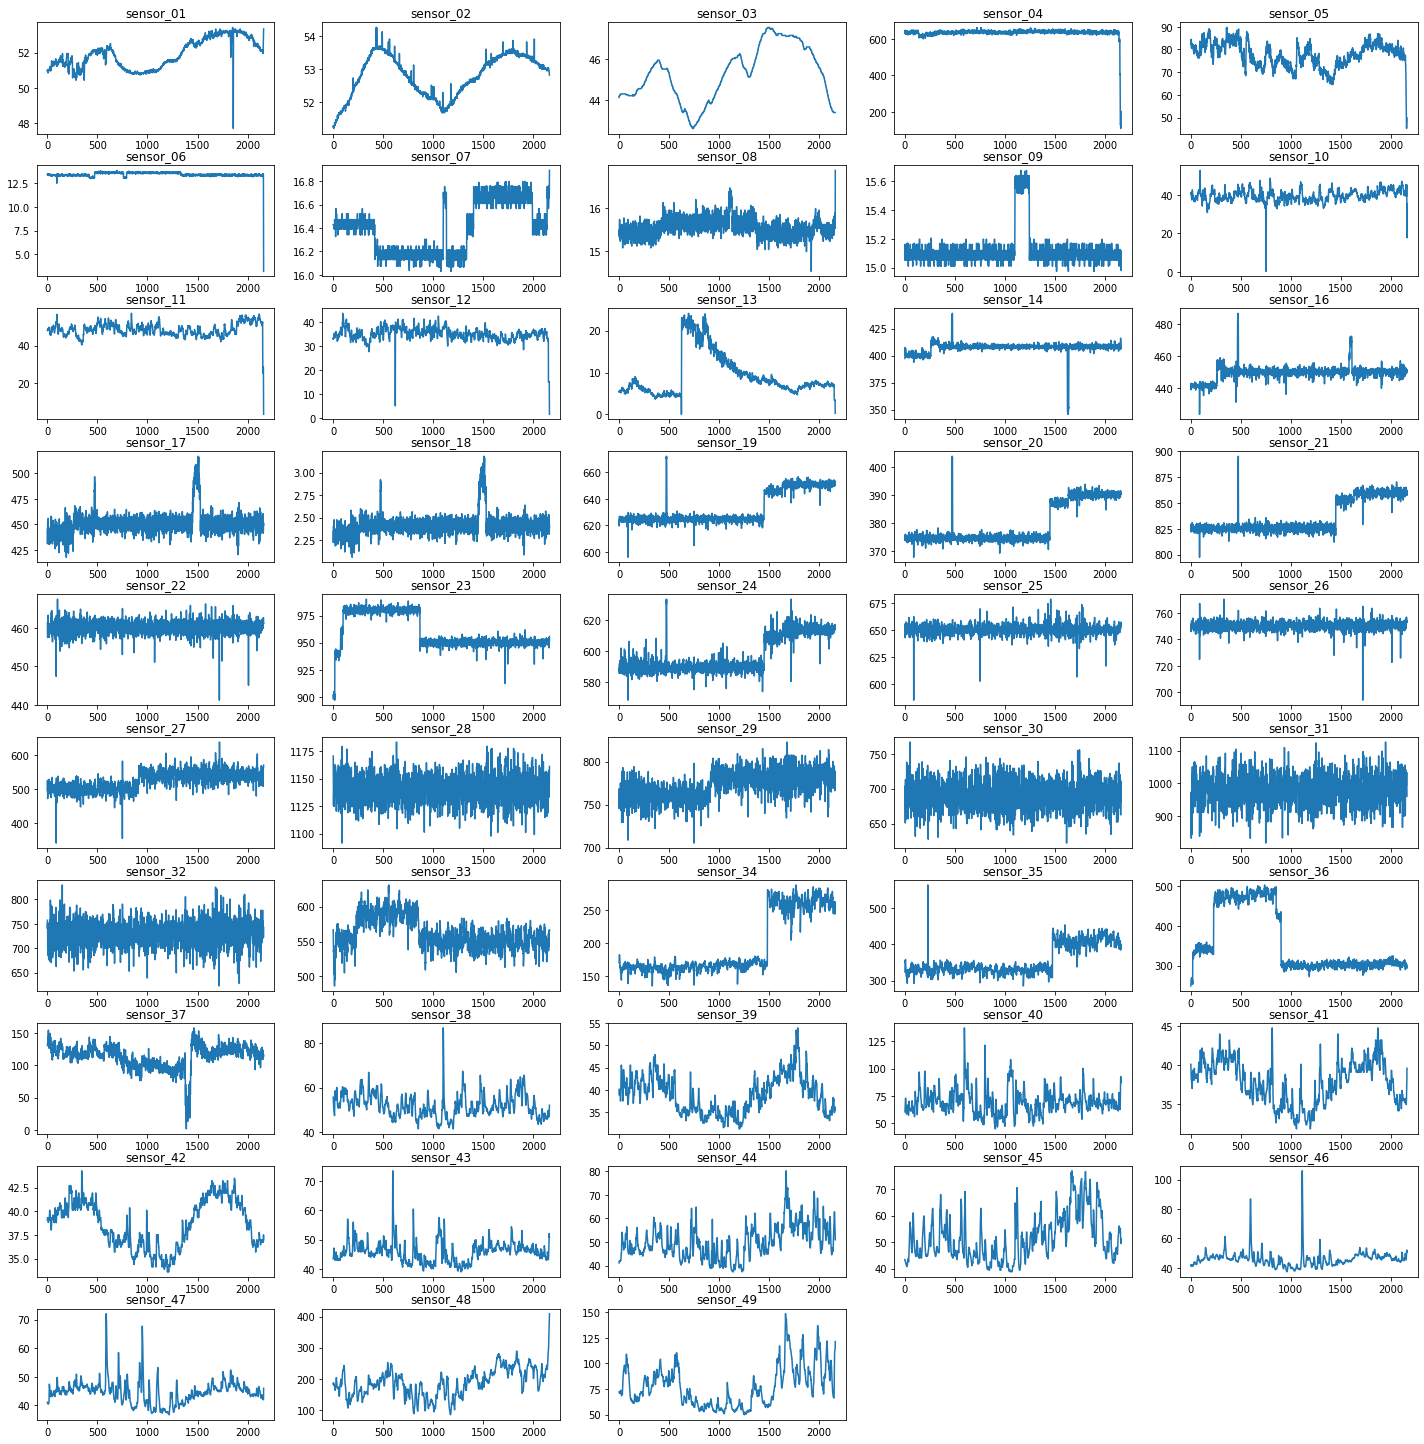

In [9]:
plot_slice(slice0)

In [10]:
for i in range(len(slices_list)):
    slices_list[i] = slices_list[i].drop(columns=["timestamp"]).to_numpy()
    slices_list[i] = np.array(slices_list[i][1:])
    print(slices_list[i].shape)


(2160, 49)
(2160, 49)
(2108, 49)
(2160, 49)
(2160, 49)
(2160, 49)


In [11]:
# from list of nps to np of nps
slices_list = np.asarray(slices_list)
slices_list.shape

/opt/app-root/lib64/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(6,)

In [ ]:
# set up DGAN config.

config = DGANConfig(
    max_sequence_len=720, # hard coded from prev shape
    sample_len=20, # trying a larger sample_len
    batch_size=min(1000, 300),
    apply_feature_scaling=True, 
    apply_example_scaling=False,
    use_attribute_discriminator=False,
    generator_learning_rate=1e-4,
    discriminator_learning_rate=1e-4,
    epochs=10000)

model = DGAN(config)

model = model.load("../models/dgan_model_4_48_sensors.pt", map_location=torch.device('cpu'))